# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from wordcloud import WordCloud, STOPWORDS

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\admin\\Downloads\\AppliedAi\\Amazon Fine Food Reviews\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 6000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (6000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID LIMIT 6000
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(5979, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.65

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID 
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(5979, 10)


1    5014
0     965
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I Love these chips for its unique taste and incredible crispy texture. Used to get them at Henry's in San Diego, CA before we moved out of there and have been ordering them from Amazon since. Running out of them constantly!
I dont like the taste of this at all.  I have some other fennel tea from another company not on amazon and it is fantastic.  Cant remember exact name but think it is something like MB - is a french company and I got it in canada and by mail order after that.  It is much better to my taste.  Never dreamed there would be this much variance among fennel seeds as only ingredient.
If you are a peanut lover, these are for you. Much larger than cocktail peanuts. Six people on my Christmas gift list ask for thes

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I Love these chips for its unique taste and incredible crispy texture. Used to get them at Henry's in San Diego, CA before we moved out of there and have been ordering them from Amazon since. Running out of them constantly!
I dont like the taste of this at all.  I have some other fennel tea from another company not on amazon and it is fantastic.  Cant remember exact name but think it is something like MB - is a french company and I got it in canada and by mail order after that.  It is much better to my taste.  Never dreamed there would be this much variance among fennel seeds as only ingredient.
If you are a peanut lover, these are for you. Much larger than cocktail peanuts. Six people on my Christmas gift list ask for these every year!!


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I dont like the taste of this at all.  I have some other fennel tea from another company not on amazon and it is fantastic.  Cant remember exact name but think it is something like MB - is a french company and I got it in canada and by mail order after that.  It is much better to my taste.  Never dreamed there would be this much variance among fennel seeds as only ingredient.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I dont like the taste of this at all I have some other fennel tea from another company not on amazon and it is fantastic Cant remember exact name but think it is something like MB is a french company and I got it in canada and by mail order after that It is much better to my taste Never dreamed there would be this much variance among fennel seeds as only ingredient 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████| 5979/5979 [00:03<00:00, 1771.57it/s]


In [23]:
preprocessed_reviews[1500]

'dont like taste fennel tea another company not amazon fantastic cant remember exact name think something like mb french company got canada mail order much better taste never dreamed would much variance among fennel seeds ingredient'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer(min_df = 10) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


'''
count_vectcount_ve  = CountVectorizer(min_df = 10) 
data = count_vect.fit_transform(x)
print("the type of count vectorizer :",type(data))
print("the shape of out text BOW vectorizer : ",data.get_shape())
print("the number of unique words :", data.get_shape()[1])'''

some feature names  ['ability', 'able', 'absolute', 'absolutely', 'acceptable', 'according', 'acid', 'acidic', 'acidity', 'across']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5979, 2525)
the number of unique words  2525


'\ncount_vectcount_ve  = CountVectorizer(min_df = 10) \ndata = count_vect.fit_transform(x)\nprint("the type of count vectorizer :",type(data))\nprint("the shape of out text BOW vectorizer : ",data.get_shape())\nprint("the number of unique words :", data.get_shape()[1])'

## [4.3] TF-IDF

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely delicious']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5979, 3711)
the number of unique words including both unigrams and bigrams  3711


## [4.4] Word2Vec

In [27]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [28]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('want', 0.9825408458709717), ('pronounced', 0.9806632399559021), ('enjoy', 0.9794275164604187), ('think', 0.979220986366272), ('excellent', 0.9773877263069153), ('anything', 0.9773264527320862), ('describe', 0.9763023853302002), ('either', 0.9762650728225708), ('feel', 0.9761450290679932), ('licorice', 0.9756050705909729)]
[('absolute', 0.998792290687561), ('disappointing', 0.9987097382545471), ('opinion', 0.9986628890037537), ('clam', 0.9986615180969238), ('mccann', 0.9985818862915039), ('produced', 0.9985288977622986), ('finish', 0.998505711555481), ('perhaps', 0.9985039830207825), ('simply', 0.9984829425811768), ('oh', 0.9984729290008545)]


In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4278
sample words  ['product', 'available', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'seasons', 'ca', 'not', 'beat', 'great', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot']


In [30]:
final.shape

(5979, 10)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 5979/5979 [00:08<00:00, 681.50it/s]


5979
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 5979/5979 [00:56<00:00, 105.04it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

In [34]:
#Plot each cluster features in a cloud
def plot_cluster_cloud(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
    print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(5, 3, figsize = (30, 20))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 50)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {} word cloud".format(i+1), fontsize = 30)
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

In [35]:
# Plot each review of a given cluster based on label
def plot_word_cloud(txt):
    # store each word from review
    cloud = " ".join(word for word in txt)
    cloud
    # Remove duplicate words
    stopwords = set(STOPWORDS) 
    # call built-in method WordCloud for creating an object for drawing a word cloud 
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords, max_words=20).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off") 
    plt.title("World cloud of reviews")
    plt.tight_layout(pad = 0)
  
    plt.show()

In [36]:
# Elbow method to find K in k_means clustering
# inertia_ is sum of squared distances of samples to their closest cluster center.
def find_optimal_k(std_data):
    loss = []
    k = list(range(2, 15))
    for noc in k:
        model = KMeans(n_clusters = noc)
        model.fit(std_data)
        loss.append(model.inertia_)
    plt.plot(k, loss, "-o")
    plt.title("Elbow method to choose k")
    plt.xlabel("K")
    plt.ylabel("Loss")
    plt.show()

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

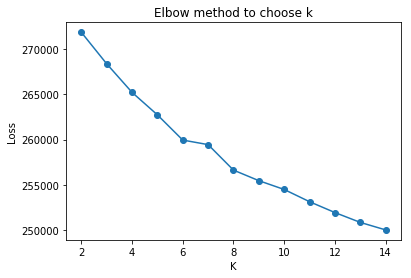

In [37]:
find_optimal_k(final_counts)

In [38]:
# training kmeans
clf = KMeans(n_clusters = 15)
clf.fit(final_counts)
pred = clf.predict(final_counts)

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

15


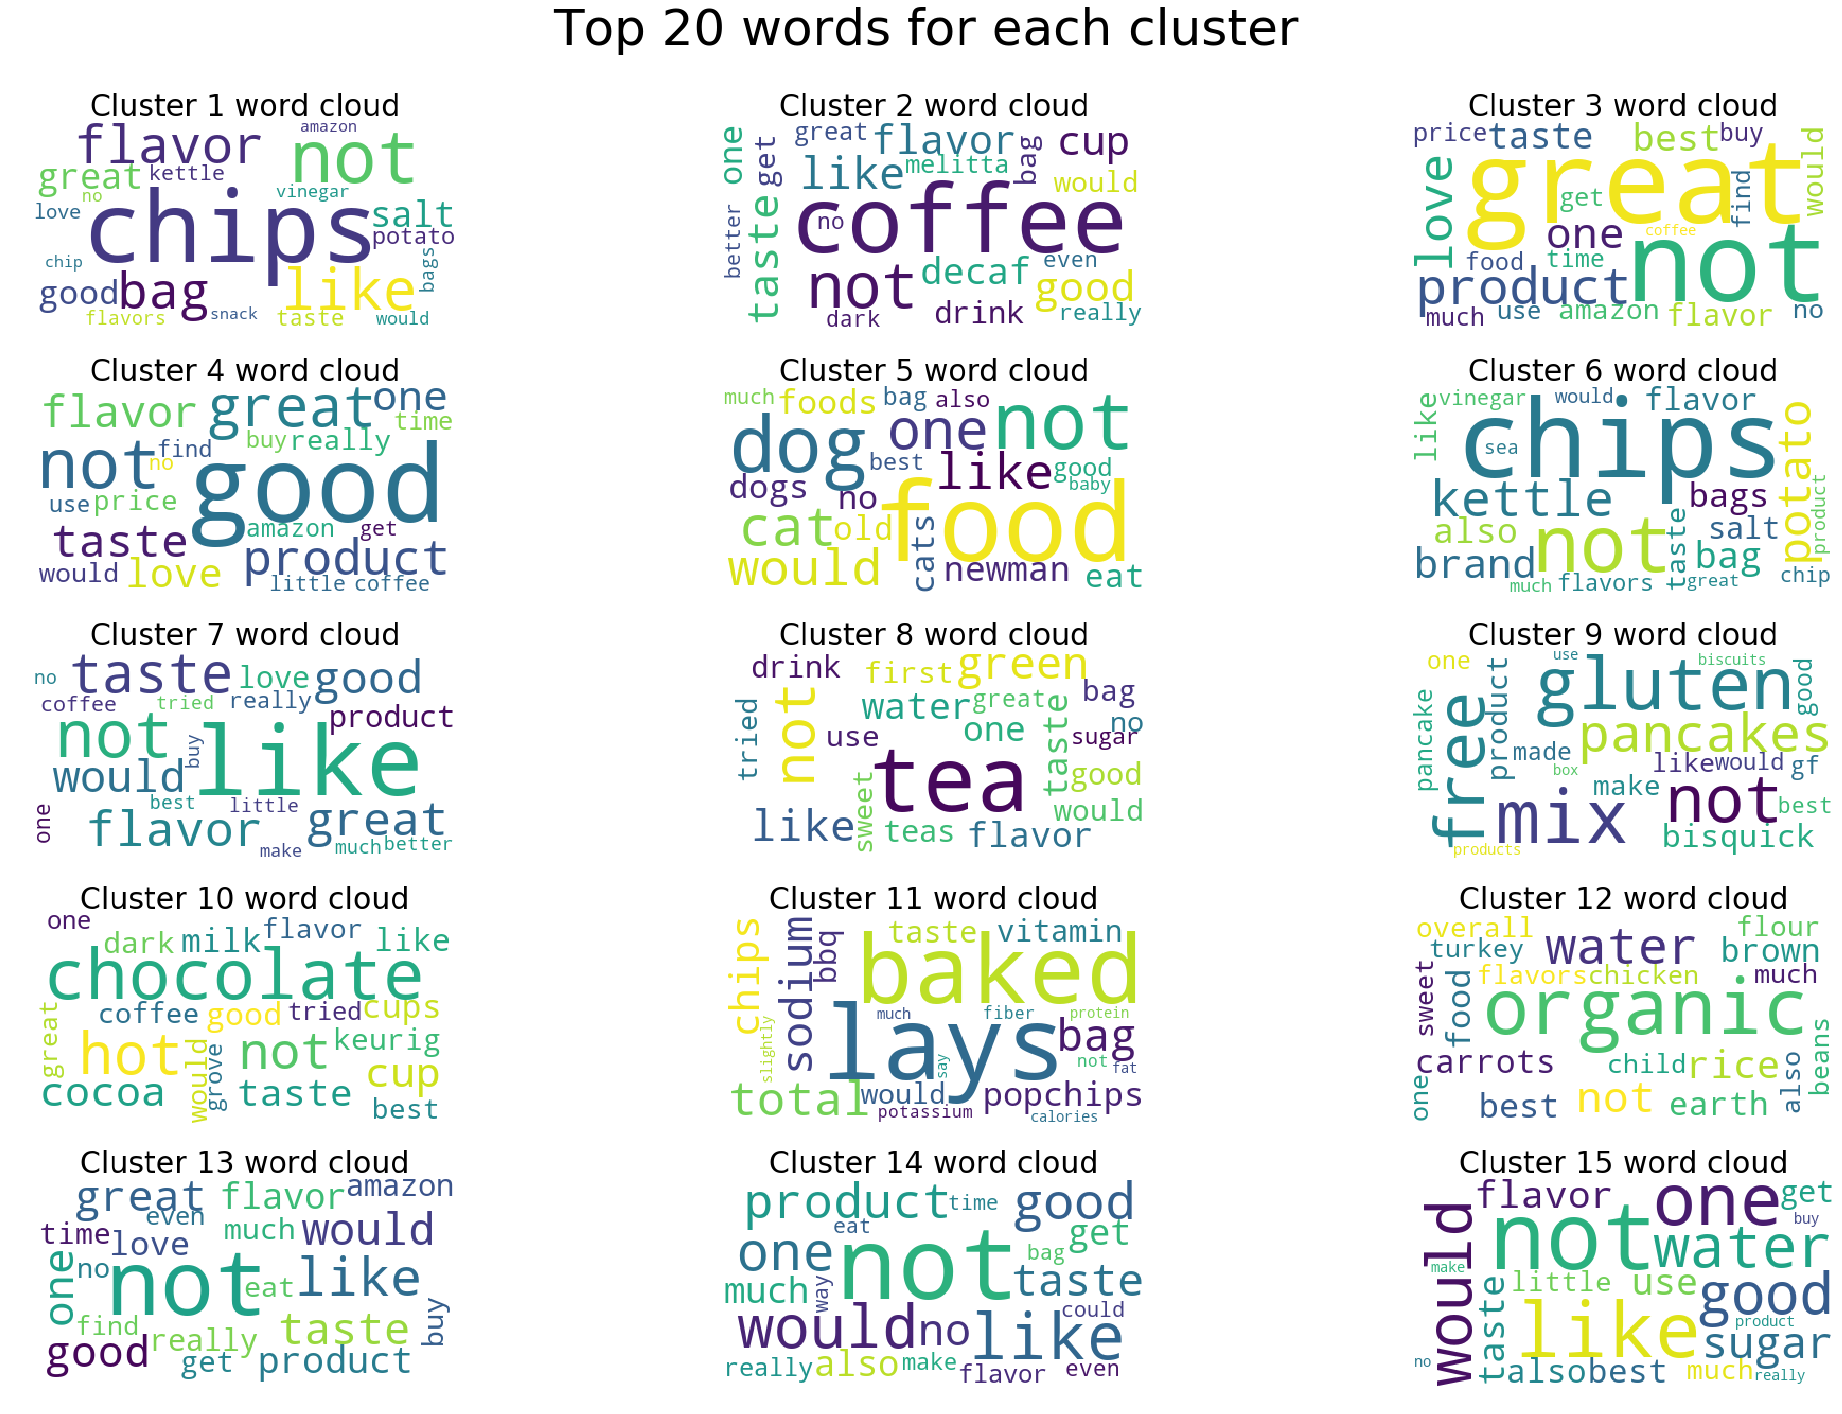

In [39]:
# getting feature names in features 
# and the cluster centers in coef
# Plot the all cluster with their corresponding features
features = count_vect.get_feature_names()
coef = clf.cluster_centers_
plot_cluster_cloud(features, coef)

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

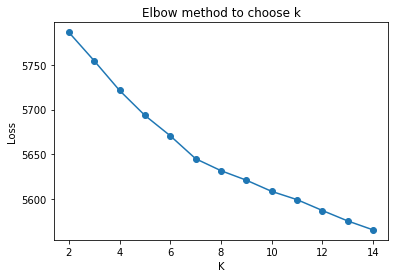

In [40]:
# Please write all the code with proper documentation
find_optimal_k(final_tf_idf)

In [ ]:
# Kmeans to 
clf = KMeans(n_clusters = 15)
clf.fit(final_tf_idf)
pred = clf.predict(final_tf_idf)

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation
features = tf_idf_vect.get_feature_names()
coef = clf.cluster_centers_
plot_cluster_cloud(features, coef)

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

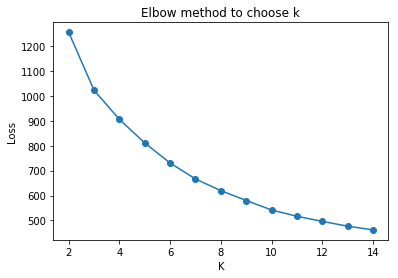

In [43]:
# Please write all the code with proper documentation
find_optimal_k(sent_vectors)

In [44]:
# KMeans Clustering
clf = KMeans(n_clusters = 10)
clf.fit(sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [45]:
# Assign each review to its cluster label
# i.e. Which review belongs to which cluster
final["cluster_label"] = clf.labels_

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

Total number of review in cluster 0 is: 977


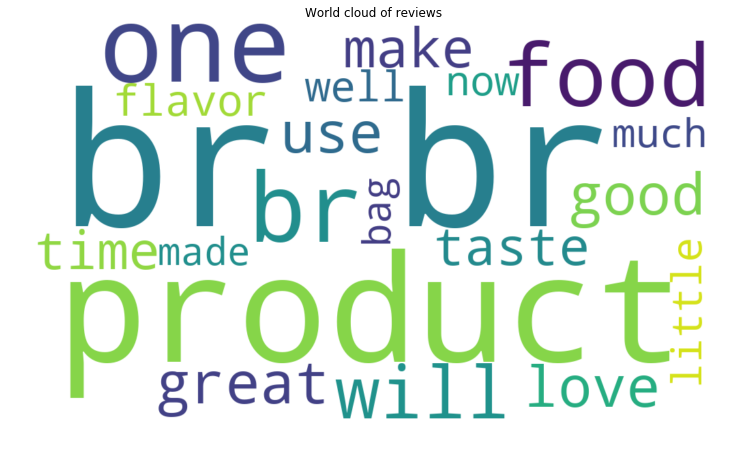

Total number of review in cluster 1 is: 831


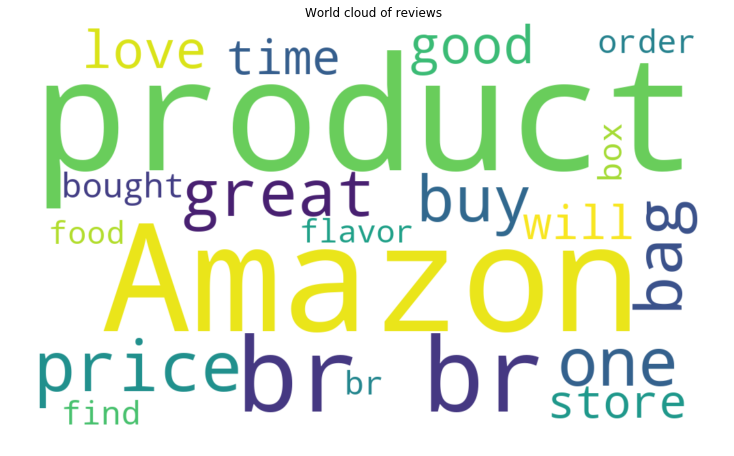

Total number of review in cluster 2 is: 964


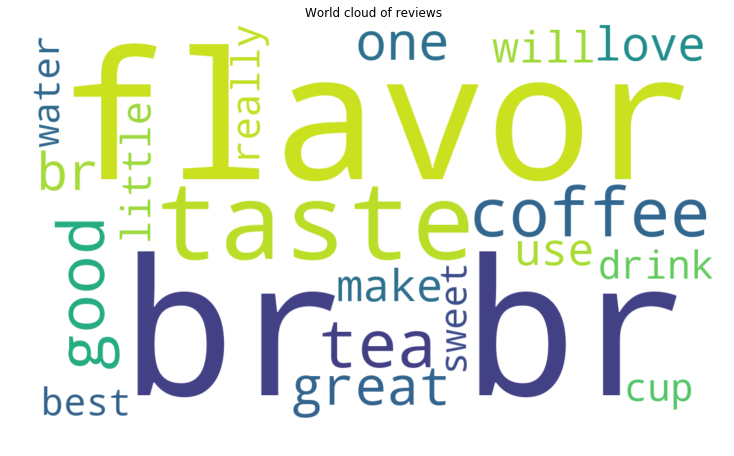

Total number of review in cluster 3 is: 821


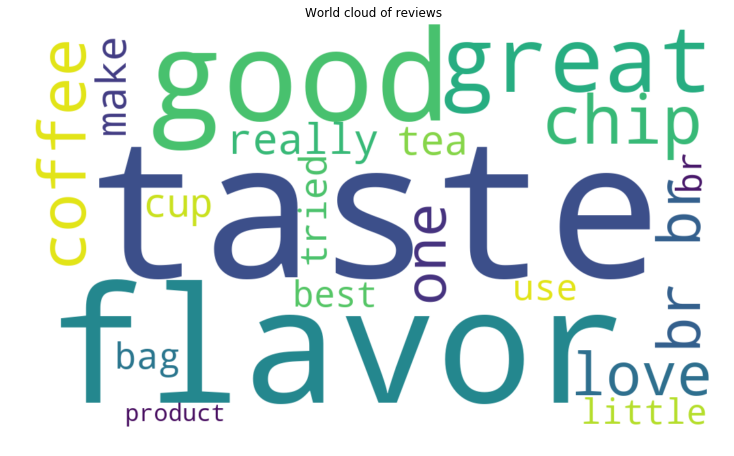

Total number of review in cluster 4 is: 327


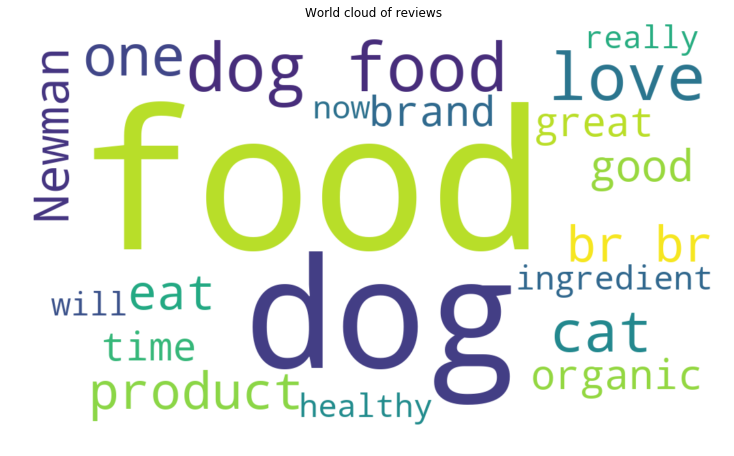

Total number of review in cluster 5 is: 141


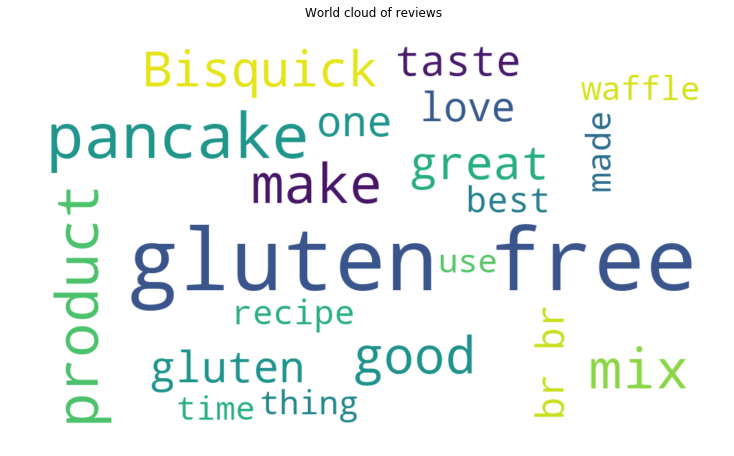

Total number of review in cluster 6 is: 17


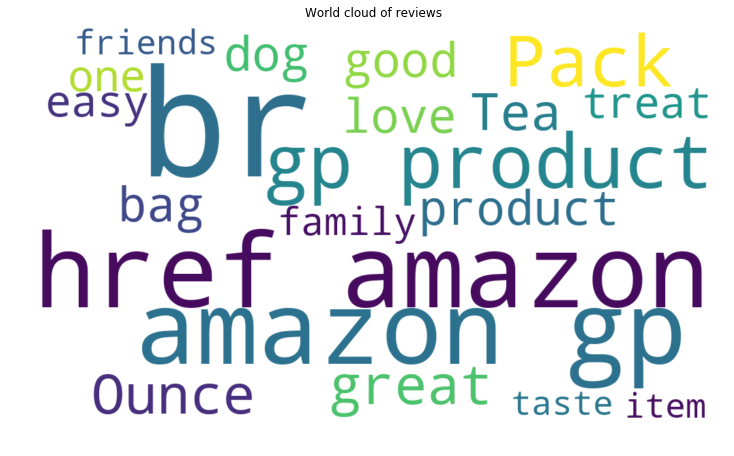

Total number of review in cluster 7 is: 370


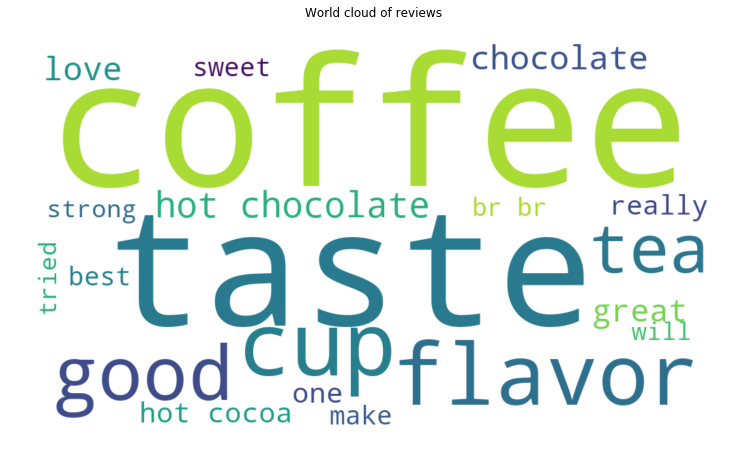

Total number of review in cluster 8 is: 1279


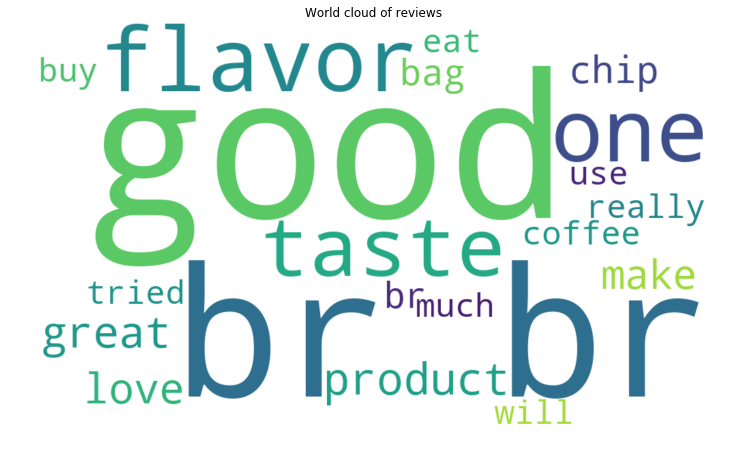

Total number of review in cluster 9 is: 252


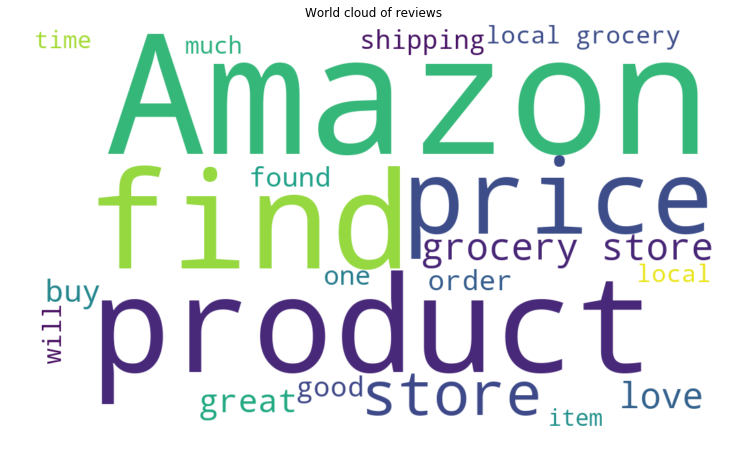

In [46]:
# For each cluster, group with its corresponding label.
for i in range(clf.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud(l)

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

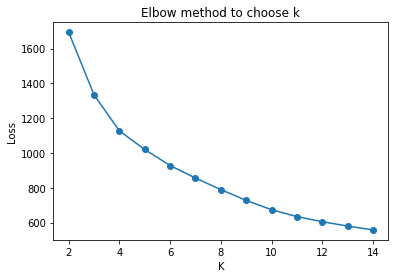

In [47]:
# Please write all the code with proper documentation

find_optimal_k(tfidf_sent_vectors)

In [48]:
# KMeans Clustering
clf = KMeans(n_clusters = 3)
clf.fit(tfidf_sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [49]:
final["cluster_label"] = clf.labels_

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

Total number of review in cluster 0 is: 1688


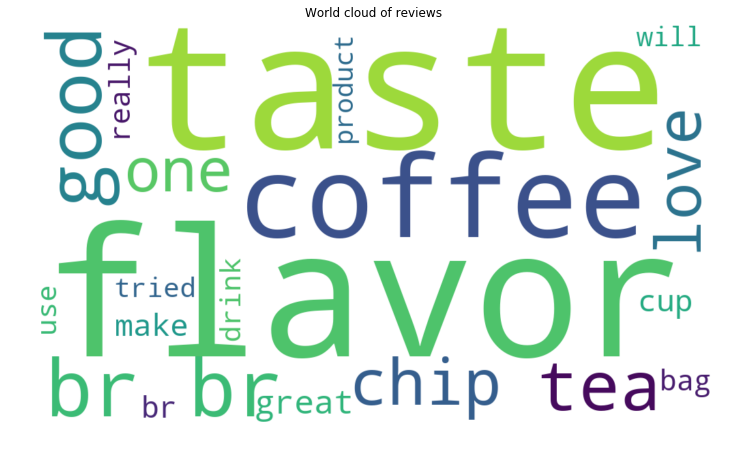

Total number of review in cluster 1 is: 1719


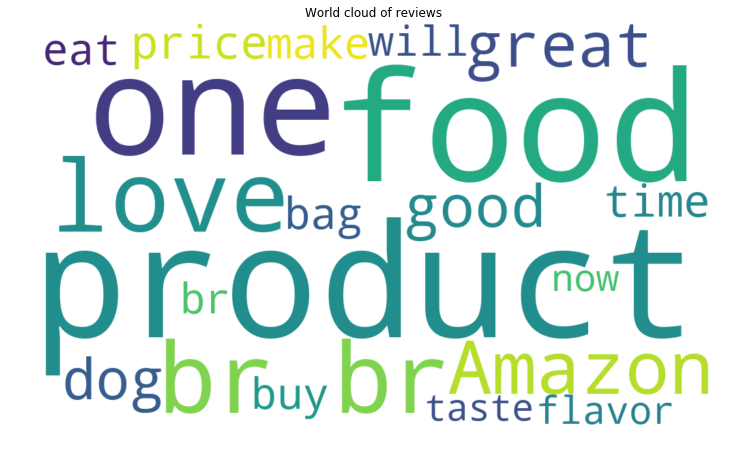

Total number of review in cluster 2 is: 2572


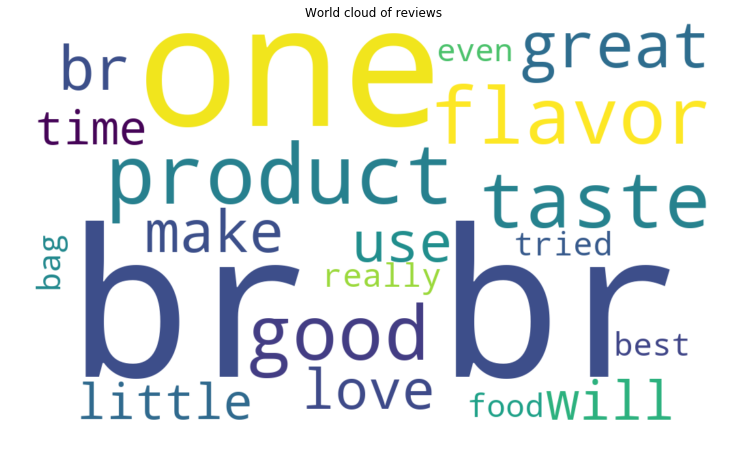

In [50]:
# For each cluster, group with its corresponding label.
for i in range(clf.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud(l)

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on BOW,<font color='red'> SET 1 </font>

In [51]:
# Please write all the code with proper documentation
final_counts=final_counts.toarray()
clf = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")
labels = clf.fit_predict(final_counts)

In [52]:
final["cluster_label"] = clf.labels_

Total number of review in cluster 0 is: 5117


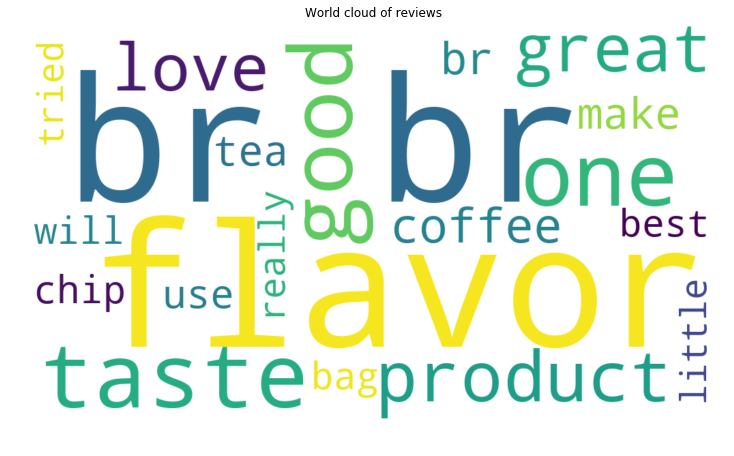

Total number of review in cluster 1 is: 862


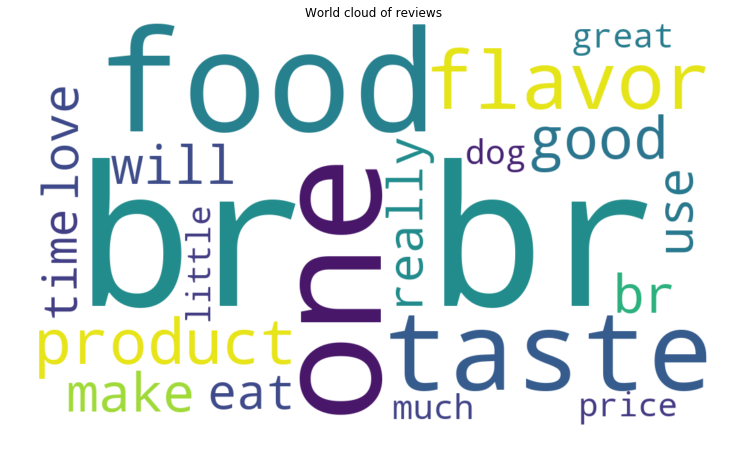

In [53]:
for i in range(clf.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud(l)

### [5.2.2] Applying Agglomerative Clustering on TF-IDF<font color='red'> SET 2</font>

In [55]:
# Please write all the code with proper documentation
#final_tf_idf=final_tf_idf.toarray()
clf = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")
labels = clf.fit_predict(final_tf_idf.toarray())

In [56]:
final["cluster_label"] = clf.labels_

Total number of review in cluster 0 is: 741


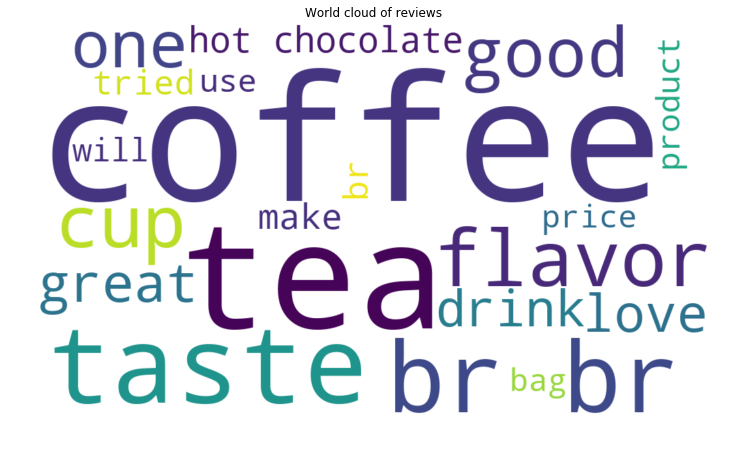

Total number of review in cluster 1 is: 5238


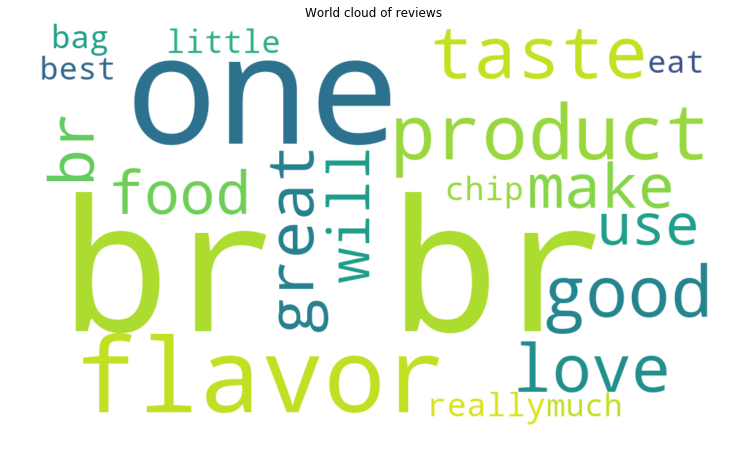

In [57]:
for i in range(clf.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud(l)

### [5.2.3] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [58]:
# Please write all the code with proper documentation
clf = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")
labels = clf.fit_predict(sent_vectors)

In [59]:
final["cluster_label"] = clf.labels_

Total number of review in cluster 0 is: 4426


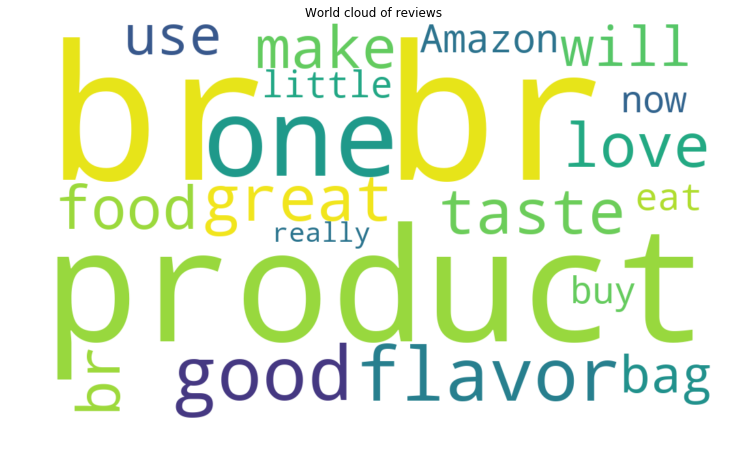

Total number of review in cluster 1 is: 1553


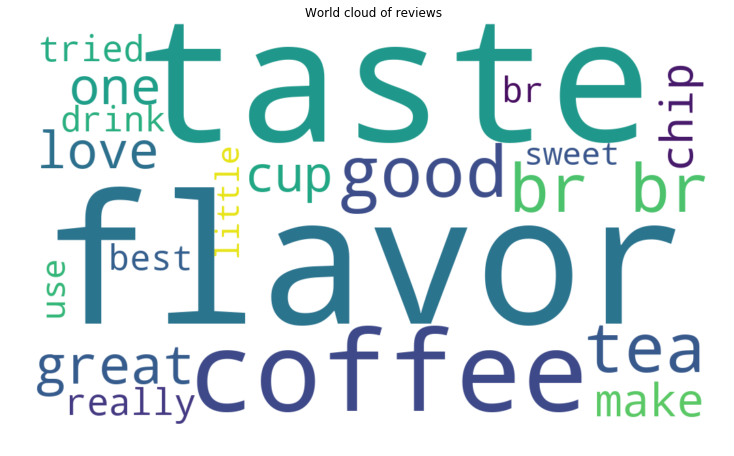

In [60]:
for i in range(clf.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud(l)

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [61]:
# Please write all the code with proper documentation
clf = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")
labels = clf.fit_predict(tfidf_sent_vectors)

In [62]:
final["cluster_label"] = clf.labels_

Total number of review in cluster 0 is: 3115


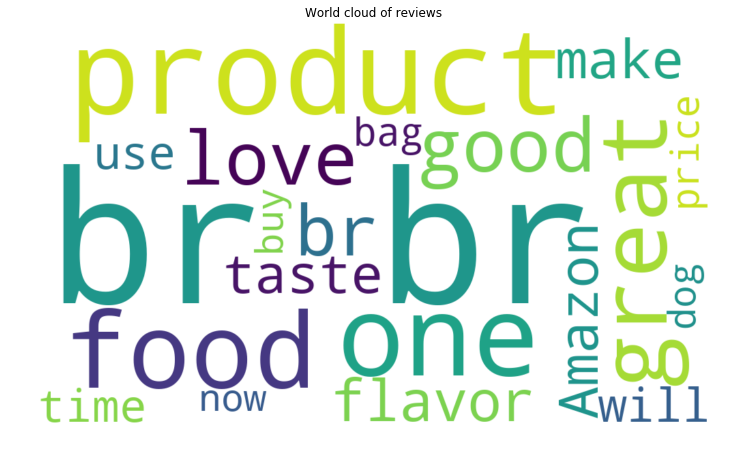

Total number of review in cluster 1 is: 2864


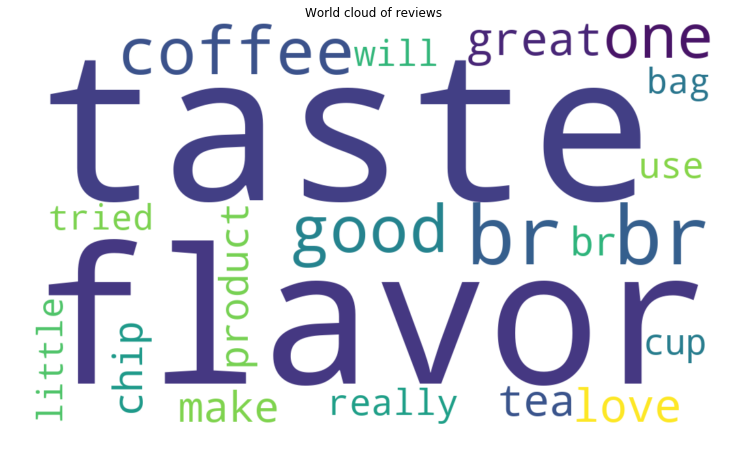

In [63]:
for i in range(clf.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    #print(label)
    #print(len(label))
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
        #print(l)
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud(l)

## [5.3] DBSCAN Clustering

In [64]:
from sklearn.neighbors import NearestNeighbors
def plot_error(data):
    nbrs=NearestNeighbors(n_neighbors=100).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distanceDec=sorted(distances[:,49])
    plt.figure(figsize=(14,4))
    plt.grid()
    plt.title("Elbow Method for finding the right Eps hyperparameter")
    plt.plot([x for x in range(5979)], distanceDec)
    plt.xlabel("Number of points")
    plt.ylabel("Distance of 100th nearest neighbour")
    plt.show()

### [5.3.1] Applying DBSCAN on BOW,<font color='red'> SET 1</font>

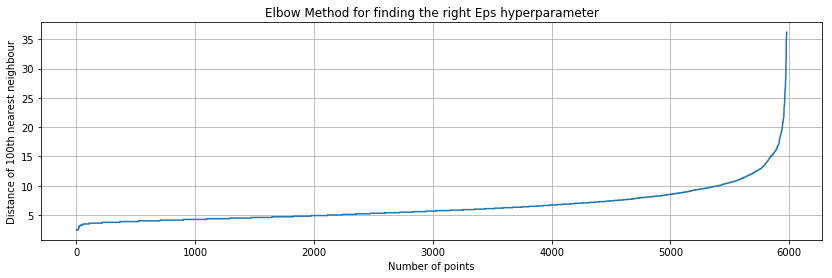

In [65]:
plot_error(final_counts)

In [105]:
db = DBSCAN(eps = 20, min_samples = 100)
db.fit(final_counts)
label = db.labels_

In [106]:
print(list(label).count(-1))
print(list(label).count(0))

28
5951


In [107]:
final["cluster_label"] = db.labels_

Total number of review in cluster -1 is: 28


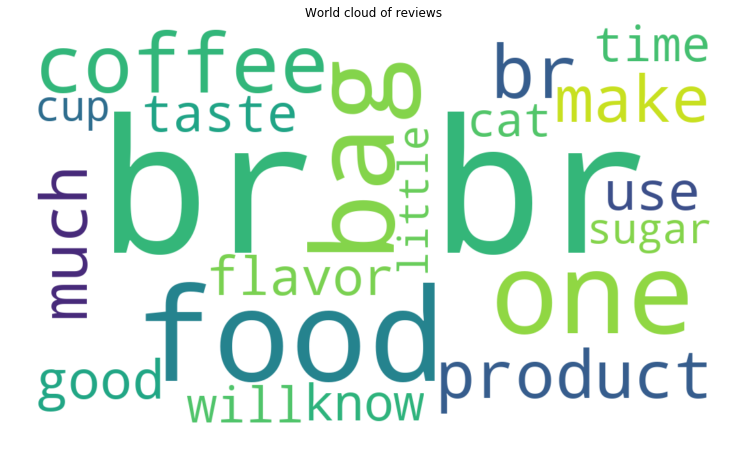

Total number of review in cluster 0 is: 5951


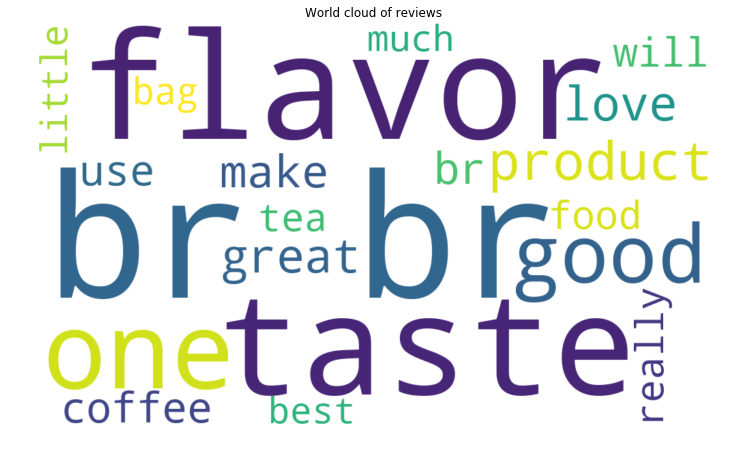

In [108]:
for i in range(-1,1):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud(l)

### [5.3.1] Applying DBSCAN on TFIDF,<font color='red'> SET 2</font>

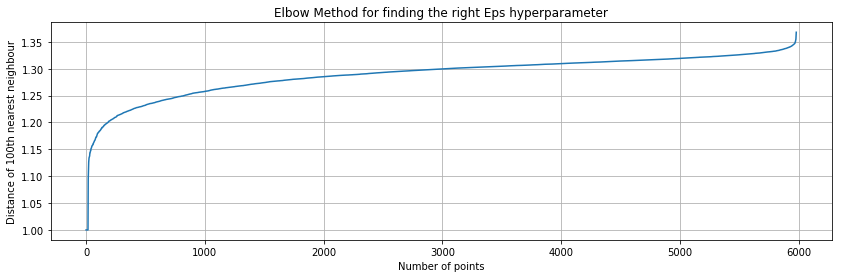

In [70]:
# Please write all the code with proper documentation
plot_error(final_tf_idf)

In [96]:
db = DBSCAN(eps = 1.30, min_samples = 50)
db.fit(final_tf_idf)
label = db.labels_

In [97]:
print(list(label).count(-1))
print(list(label).count(0))

0
5979


In [98]:
final["cluster_label"] = db.labels_

Total number of review in cluster 0 is: 5979


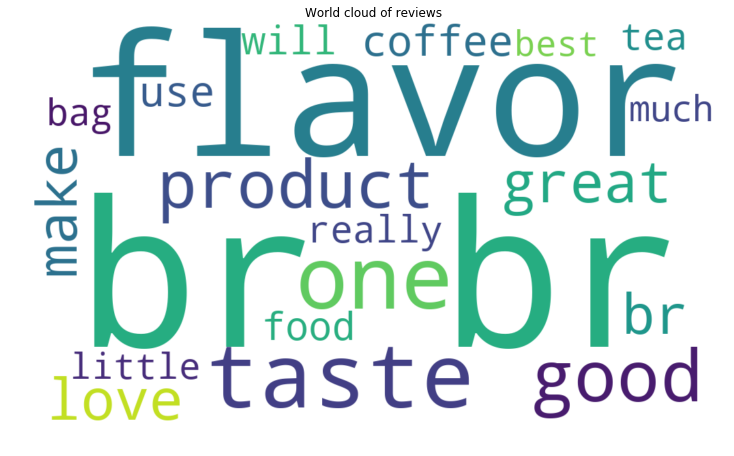

In [100]:
for i in range(0,1):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud(l)

### [5.3.2]Applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

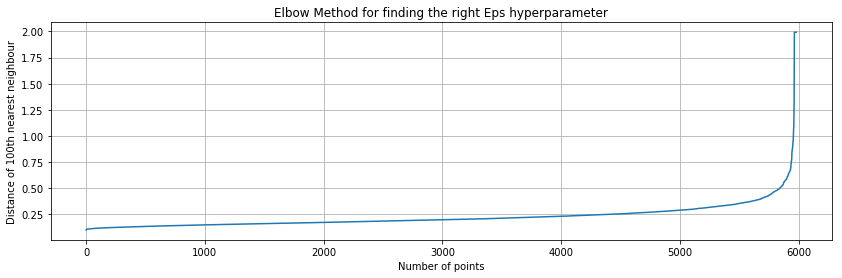

In [75]:
# Please write all the code with proper documentation
plot_error(sent_vectors)

In [101]:
db = DBSCAN(eps = 0.5, min_samples = 100)
db.fit(sent_vectors)
label = db.labels_

In [102]:
print(list(label).count(-1))
print(list(label).count(0))

51
5928


In [103]:
final["cluster_label"] = db.labels_

Total number of review in cluster -1 is: 51


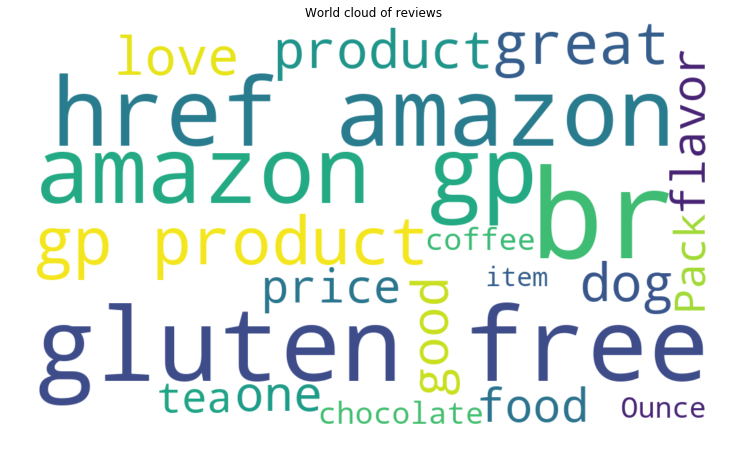

Total number of review in cluster 0 is: 5928


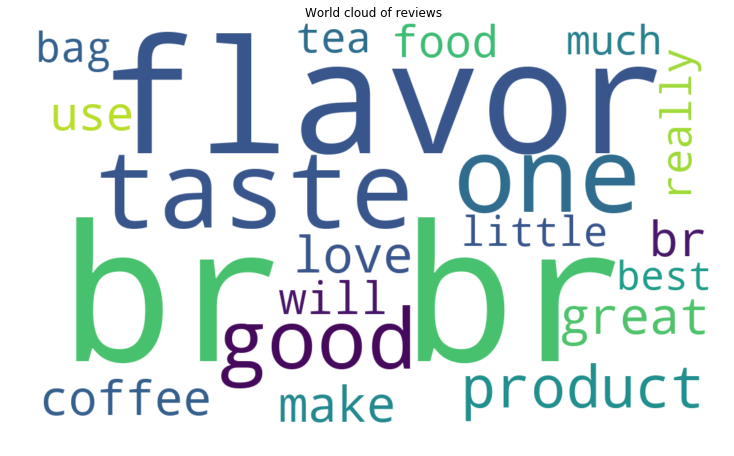

In [104]:
for i in range(-1,1):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud(l)

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

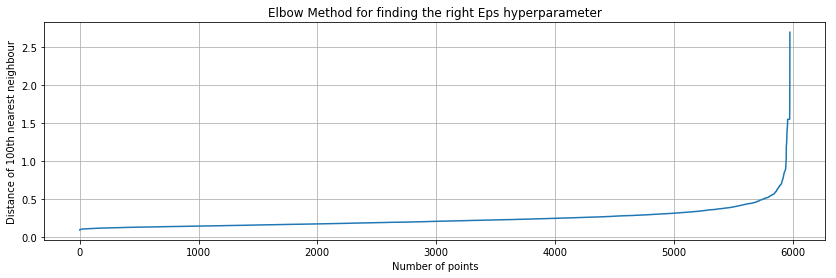

In [80]:
# Please write all the code with proper documentation
plot_error(tfidf_sent_vectors)

In [81]:
db = DBSCAN(eps = 0.5, min_samples = 50)
db.fit(tfidf_sent_vectors)
label = db.labels_

In [82]:
print(list(label).count(-1))
print(list(label).count(0))

56
5923


In [83]:
final["cluster_label"] = db.labels_

Total number of review in cluster -1 is: 56


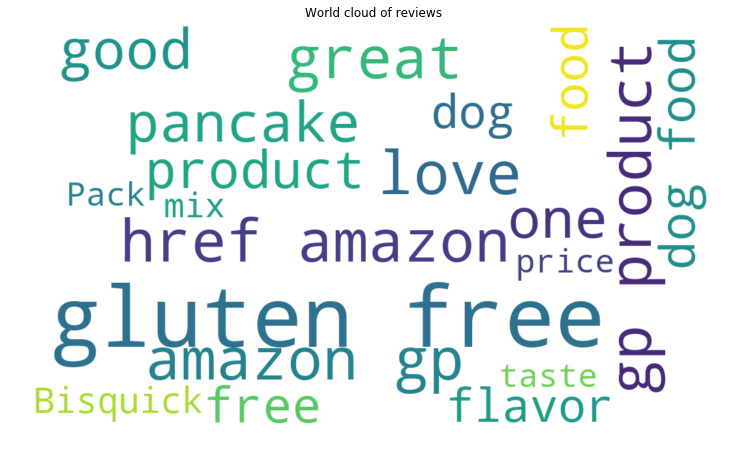

Total number of review in cluster 0 is: 5923


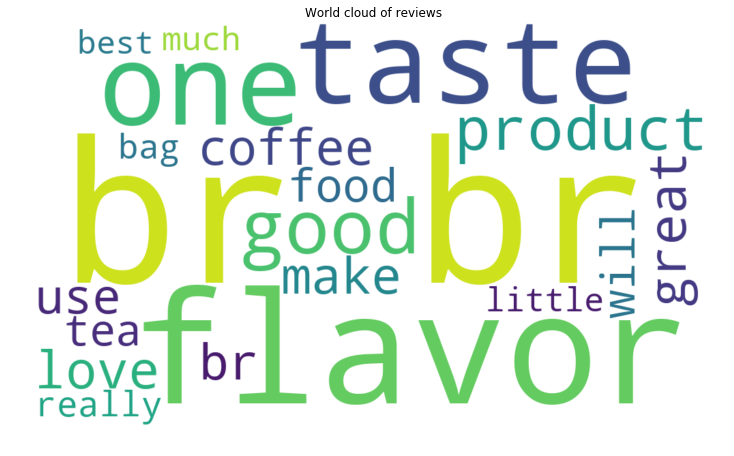

In [95]:
'''for i in range(len(set(label))):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud(l)'''
    
for i in range(-1,1):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud(l)

# [6] Conclusions


We observe that kmeans and agglomerative clustering performed better than DBSCAN.
We can say this by observing the wordclouds for each model.
In DBSCAN we can say that it not good as it clustered everything in a single cluster and as the review given by user is not same type of review.

In [110]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Clustering","Model","Hyper-parameter"]
x.add_row(["K-Means", "BOW","n_clusters=15"])
x.add_row(["K-Means", "TF-IDF","n_clusters=15"])
x.add_row(["K-Means", "AVG-W2V","n_clusters=10"])
x.add_row(["K-Means", "TFIDF-W2V","n_clusters=3"])
x.add_row(["Agglomerative Clustering", "BOW","n_clusters=2"])
x.add_row(["Agglomerative Clustering", "TF-IDF","n_clusters=2"])
x.add_row(["Agglomerative Clustering", "AVG-W2V","n_clusters=2"])
x.add_row(["Agglomerative Clustering", "TFIDF-W2V","n_clusters=2"])
x.add_row(["DBSCAN", "BOW","eps=20"])
x.add_row(["DBSCAN", "TF-IDF","eps=1.30"])
x.add_row(["DBSCAN", "AVG-W2V","eps=0.5"])
x.add_row(["DBSCAN", "TFIDF-W2V","eps=0.5"])
print(x)

+--------------------------+-----------+-----------------+
|        Clustering        |   Model   | Hyper-parameter |
+--------------------------+-----------+-----------------+
|         K-Means          |    BOW    |  n_clusters=15  |
|         K-Means          |   TF-IDF  |  n_clusters=15  |
|         K-Means          |  AVG-W2V  |  n_clusters=10  |
|         K-Means          | TFIDF-W2V |   n_clusters=3  |
| Agglomerative Clustering |    BOW    |   n_clusters=2  |
| Agglomerative Clustering |   TF-IDF  |   n_clusters=2  |
| Agglomerative Clustering |  AVG-W2V  |   n_clusters=2  |
| Agglomerative Clustering | TFIDF-W2V |   n_clusters=2  |
|          DBSCAN          |    BOW    |      eps=20     |
|          DBSCAN          |   TF-IDF  |     eps=1.30    |
|          DBSCAN          |  AVG-W2V  |     eps=0.5     |
|          DBSCAN          | TFIDF-W2V |     eps=0.5     |
+--------------------------+-----------+-----------------+
